In [1]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import time

t0 = time.time()

print("loading...")

# Read recipe inputs
NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT = dataiku.Dataset("NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT")
NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT.get_dataframe()

NAFCUSTOMER_REVENUE_AGGREGATED = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED")
NAFCUSTOMER_REVENUE_AGGREGATED_df = NAFCUSTOMER_REVENUE_AGGREGATED.get_dataframe()

t1 = time.time()
print("load duration", (t1-t0)/60.0, "minutes")

loading...
load duration 9.379929351806641 minutes


In [2]:
print(len(NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df), "rows in NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT")
df_a = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df.copy()

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df), "rows in NAFCUSTOMER_REVENUE_AGGREGATED")
df = NAFCUSTOMER_REVENUE_AGGREGATED_df.copy()

2319568 rows in NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT
18075044 rows in NAFCUSTOMER_REVENUE_AGGREGATED


In [34]:
df_active_card_count_by_customer = df_a.groupby(['CUSTOMER_ID','CUSTOMER','YEAR_NUMBER']).ACTIVE_CARD_COUNT.sum().reset_index()
df_active_card_count_by_customer['FLEET_SIZE'] = 'NOT SET'
df_active_card_count_by_customer.loc[df_active_card_count_by_customer.ACTIVE_CARD_COUNT.between(0,20),'FLEET_SIZE'] = '(<=20 cards)'
df_active_card_count_by_customer.loc[df_active_card_count_by_customer.ACTIVE_CARD_COUNT>20,'FLEET_SIZE'] = '(>20 cards)'

df_active_card_count_by_year = df_active_card_count_by_customer.groupby(['YEAR_NUMBER','FLEET_SIZE']).ACTIVE_CARD_COUNT.sum().reset_index()
df_active_card_count_by_year.head(10)

,YEAR_NUMBER,FLEET_SIZE,ACTIVE_CARD_COUNT
0,2019,(<=20 cards),1937429
1,2019,(>20 cards),6477104
2,2020,(<=20 cards),1966134
3,2020,(>20 cards),6142386
4,2021,(<=20 cards),2141029
5,2021,(>20 cards),6650870
6,2022,(<=20 cards),2310830
7,2022,(>20 cards),7639200


AttributeError: 'Rectangle' object has no property 'c'

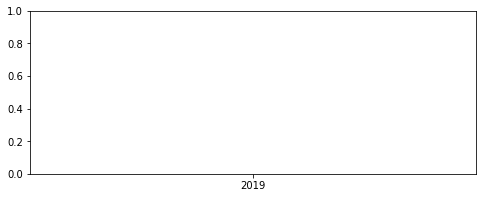

In [49]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

    
fig, ax1 = plt.subplots(figsize=(8,3))

dim1 = list(map(str,df_active_card_count_by_year[df_active_card_count_by_year.FLEET_SIZE=='(>20 cards)'].YEAR_NUMBER))
data1 = df_active_card_count_by_year[df_active_card_count_by_year.FLEET_SIZE=='(>20 cards)'].ACTIVE_CARD_COUNT

dim2 = list(map(str,df_active_card_count_by_year[df_active_card_count_by_year.FLEET_SIZE=='(<=20 cards)'].YEAR_NUMBER))
data2 = df_active_card_count_by_year[df_active_card_count_by_year.FLEET_SIZE=='(<=20 cards)'].ACTIVE_CARD_COUNT

ax1.bar(dim1,data1, c='#006BA2')
ax1.bar(dim2,data2, bottom=data1, c='758D99')

ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('ACTIVE CARDS', fontsize=14)
ax1.set_ylim(ymin=0, ymax=max_value*1.15)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.6)
fig.autofmt_xdate()
plt.show()

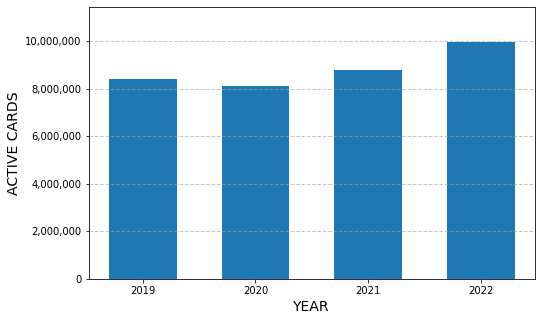

In [30]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

chart_revenue_year = [] 
for y in df_active_card_count_by_year.YEAR_NUMBER.tolist():
    chart_revenue_year.append(str(y))
    
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.bar(chart_revenue_year, df_active_card_count_by_year['ACTIVE_CARD_COUNT'], width=0.6)
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('ACTIVE CARDS', fontsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_ylim(ymin=0, ymax=max_value*1.15)
ax1.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.6)
plt.show()

In [0]:
# Compute recipe outputs
# TODO: Write here your actual code that computes the outputs
# NB: DSS supports several kinds of APIs for reading and writing data. Please see doc.

#RETENTION_RATE_BY_GROUP_df = ... # Compute a Pandas dataframe to write into RETENTION_RATE_BY_GROUP

# Write recipe outputs
#RETENTION_RATE_BY_GROUP = dataiku.Dataset("RETENTION_RATE_BY_GROUP")
#RETENTION_RATE_BY_GROUP.write_with_schema(RETENTION_RATE_BY_GROUP_df)